# IDENTIFICATION OF PROSPECTIVE CUSTOMERS FOR CAR INSURANCE

To predict customers who are contacted during the current campaign, whether they will buy car insurance or not.

In [1]:
# IMPORTING NECESSARY LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score,cross_val_predict,KFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
# LOADING TRAIN DATA

train_df = pd.read_csv("carInsurance_train.csv")
print("----DATASET LOADED----")

----DATASET LOADED----


In [3]:
# PREVIEW OF THE DATA

train_df.head()

Id  Age          Job  Marital Education  Default  Balance  HHInsurance  \
0   1   32   management   single  tertiary        0     1218            1   
1   2   32  blue-collar  married   primary        0     1156            1   
2   3   29   management   single  tertiary        0      637            1   
3   4   25      student   single   primary        0      373            1   
4   5   30   management  married  tertiary        0     2694            0   

   CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
0        0     telephone              28              jan             2   
1        0           NaN              26              may             5   
2        0      cellular               3              jun             1   
3        0      cellular              11              may             2   
4        0      cellular               3              jun             1   

   DaysPassed  PrevAttempts  Outcome CallStart   CallEnd  CarInsurance  
0          -1             0      NaN  13:45:20  13:46:30             0  
1          -1             0      NaN  14:49:03  14:52:08             0  
2         119             1  failure  16:30:24  16:36:04             1  
3          -1             0      NaN  12:06:43  12:20:22             1  
4          -1             0      NaN  14:35:44  14:38:56             0

In [4]:
# DIMENSION OF THE DATA

train_df.shape

(4000, 19)

The dataset contains 19 attributes and 4000 records of data

In [5]:
# DATASET DESCRIPTION

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

The dataset contains both numercal and categorical data types.

PREPROCESSING

In [6]:
from copy import deepcopy

train_data = deepcopy(train_df)

In [7]:
# CHECKING MISSING VALUES

train_data.isna().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

The dataset contains missing values from four attributes namely Job, Education, Communication and Outcome.

<AxesSubplot:>

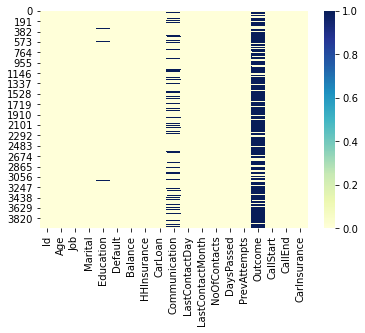

In [8]:
# VISUALIZING MISSING VALUES

sns.heatmap(data = train_data.isna(),cmap="YlGnBu")

In [9]:
# PERCENTAGES OF MISSING VALUES IN EACH ATTRIBUTE

print("PERCENTAGES OF MISSING VALUES OF THE ATTRIBUTE \n")

Dict = {}
for Column, Value in train_data.isnull().sum().items():
    if (Value > 0):
        Dict[Column] = Value
      
for col,val in Dict.items():
    print(col," : ",val,"\nPercentage : ",(val/4000)*100,"%\n")

PERCENTAGES OF MISSING VALUES OF THE ATTRIBUTE 

Job  :  19 
Percentage :  0.475 %

Education  :  169 
Percentage :  4.2250000000000005 %

Communication  :  902 
Percentage :  22.55 %

Outcome  :  3042 
Percentage :  76.05 %



Outcome has the highest missing percentage compared to others of about 76%.

In [10]:
# MAPPING CATEGORICAL COLUMNS

train_data['Communication'] = train_data.Communication.map({'telephone' : 0, 'cellular' : 1})
train_data['Education'] =train_data.Education.map({'primary' : 1 , 'secondary' : 2, 'tertiary' : 3})
train_data['Marital'] = train_data.Marital.map({'single' : 1, 'married' : 2, 'divorced': 3})
train_data['LastContactMonth'] = train_data.LastContactMonth.map({'jan' :1, 'feb' : 2, 'mar' : 3, 'apr'  :4, 'may' :5, 'jun' : 6, 'jul' : 7, 'aug' :8, 'sep':9,  'oct' :10, 'nov' :11, 'dec' :12})

In [11]:
# HANDLING MISSING VALUES

def impute_nan(df,variable):
    most_frequent_category=df[variable].value_counts().mode()[0]
    df[variable].fillna(most_frequent_category,inplace=True)
    
for feature in ['Job','Education','Communication']:
    impute_nan(train_data,feature)


In [12]:
# ENCODING JOB FEATURES

def onehot_encode(train_data, columns):
    dummies = pd.get_dummies(train_data[columns], prefix = columns)
    train_data = pd.concat([train_data, dummies], axis =1)
    train_data = train_data.drop(columns, axis=1)
    
    return train_data

train_data = onehot_encode(train_data, 'Job')

In [13]:
# DROP OF OUTCOME ATTRIBUTE

train_data.drop(['Outcome'],axis =1, inplace = True)

In [14]:
# AFTER MAPPING AND TREATING MISSING VALUES

train_data.isnull().sum()

Id                   0
Age                  0
Marital              0
Education            0
Default              0
Balance              0
HHInsurance          0
CarLoan              0
Communication        0
LastContactDay       0
LastContactMonth     0
NoOfContacts         0
DaysPassed           0
PrevAttempts         0
CallStart            0
CallEnd              0
CarInsurance         0
Job_109              0
Job_admin.           0
Job_blue-collar      0
Job_entrepreneur     0
Job_housemaid        0
Job_management       0
Job_retired          0
Job_self-employed    0
Job_services         0
Job_student          0
Job_technician       0
Job_unemployed       0
dtype: int64

After mapping, now the dataset doesnot contains any missing values.

<AxesSubplot:>

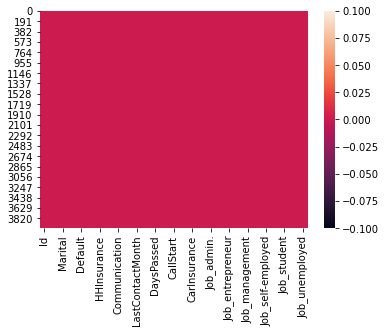

In [15]:
# VISUALIZING THE MISSING VALUES

sns.heatmap(data = train_data.isna())

In [16]:
# CALCULATING TOTAL CALL DURATION AND CONVERTING IT TO SECONDS

# Converting the type of "CallStart" & "CallEnd" to Datetime.
train_data[['CallStart','CallEnd']]=train_data[['CallStart','CallEnd']].astype('datetime64[ns]')

# Calculating the total Call Duration
train_data['Call_Duration']=train_data['CallEnd']-train_data['CallStart']

# Extracting the time & converting it to seconds
train_data['Call_Duration']=train_data['Call_Duration'].dt.components['minutes']*60 + train_data['Call_Duration'].dt.components['seconds']
train_data['Call_Duration'].head()

0     70
1    185
2    340
3    819
4    192
Name: Call_Duration, dtype: int64

In [17]:
# AFTER ADDING CALL DURATION

train_data.head()

Id  Age  Marital  Education  Default  Balance  HHInsurance  CarLoan  \
0   1   32        1        3.0        0     1218            1        0   
1   2   32        2        1.0        0     1156            1        0   
2   3   29        1        3.0        0      637            1        0   
3   4   25        1        1.0        0      373            1        0   
4   5   30        2        3.0        0     2694            0        0   

   Communication  LastContactDay  ...  Job_entrepreneur  Job_housemaid  \
0            0.0              28  ...                 0              0   
1          267.0              26  ...                 0              0   
2            1.0               3  ...                 0              0   
3            1.0              11  ...                 0              0   
4            1.0               3  ...                 0              0   

   Job_management  Job_retired Job_self-employed Job_services  Job_student  \
0               1            0                 0            0            0   
1               0            0                 0            0            0   
2               1            0                 0            0            0   
3               0            0                 0            0            1   
4               1            0                 0            0            0   

   Job_technician  Job_unemployed  Call_Duration  
0               0               0             70  
1               0               0            185  
2               0               0            340  
3               0               0            819  
4               0               0            192  

[5 rows x 30 columns]

In [18]:
# DROP OF UNWANTED COLUMNS

train_data.drop(['Id'],axis =1, inplace = True)
train_data.drop(['CallEnd', 'CallStart'], axis=1, inplace=True)

In [19]:
# AFTER PREPROCESSING DATASET PREVIEW

train_data.head()

Age  Marital  Education  Default  Balance  HHInsurance  CarLoan  \
0   32        1        3.0        0     1218            1        0   
1   32        2        1.0        0     1156            1        0   
2   29        1        3.0        0      637            1        0   
3   25        1        1.0        0      373            1        0   
4   30        2        3.0        0     2694            0        0   

   Communication  LastContactDay  LastContactMonth  ...  Job_entrepreneur  \
0            0.0              28                 1  ...                 0   
1          267.0              26                 5  ...                 0   
2            1.0               3                 6  ...                 0   
3            1.0              11                 5  ...                 0   
4            1.0               3                 6  ...                 0   

   Job_housemaid  Job_management  Job_retired  Job_self-employed  \
0              0               1            0                  0   
1              0               0            0                  0   
2              0               1            0                  0   
3              0               0            0                  0   
4              0               1            0                  0   

   Job_services  Job_student  Job_technician  Job_unemployed  Call_Duration  
0             0            0               0               0             70  
1             0            0               0               0            185  
2             0            0               0               0            340  
3             0            1               0               0            819  
4             0            0               0               0            192  

[5 rows x 27 columns]

In [20]:
# CHECKING INFORMATION ABOUT DATA AFTER PREPROCESSING

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                4000 non-null   int64  
 1   Marital            4000 non-null   int64  
 2   Education          4000 non-null   float64
 3   Default            4000 non-null   int64  
 4   Balance            4000 non-null   int64  
 5   HHInsurance        4000 non-null   int64  
 6   CarLoan            4000 non-null   int64  
 7   Communication      4000 non-null   float64
 8   LastContactDay     4000 non-null   int64  
 9   LastContactMonth   4000 non-null   int64  
 10  NoOfContacts       4000 non-null   int64  
 11  DaysPassed         4000 non-null   int64  
 12  PrevAttempts       4000 non-null   int64  
 13  CarInsurance       4000 non-null   int64  
 14  Job_109            4000 non-null   uint8  
 15  Job_admin.         4000 non-null   uint8  
 16  Job_blue-collar    4000 

After preprocessing, the dataset contains 27 attributes (columns) with 4000 records and the attributes are numerical data.

EXPLORATORY DATA ANALYSIS

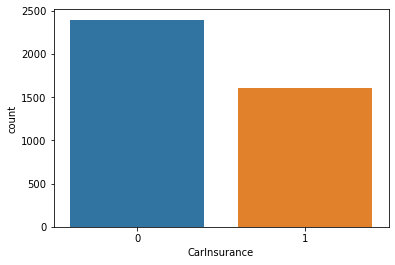

In [21]:
# COUNT PLOT OF CAR INSURANCE

sns.countplot(train_df["CarInsurance"])
plt.show()


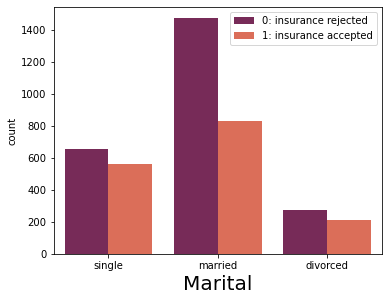

In [22]:
# COUNT PLOT FOR MARITAL STATUS 

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.xlabel("Marital", fontsize=20)
sns.countplot(x="Marital" ,hue='CarInsurance', data=train_df ,palette='rocket')
plt.legend(("0: insurance rejected", "1: insurance accepted"),loc='best')



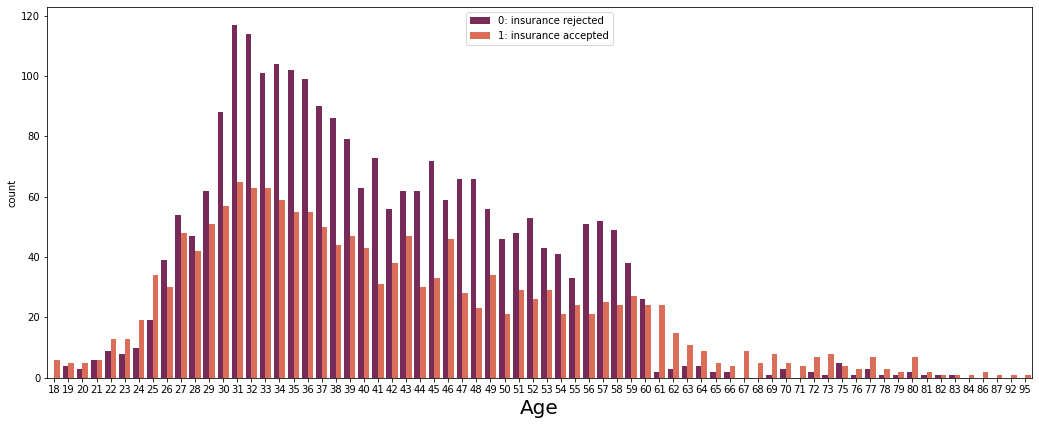

In [23]:
# COUNT PLOT OF AGE


plt.figure(figsize=(60,15))
plt.subplot(2,3,1)
plt.xlabel("Age", fontsize=20)
sns.countplot(x="Age" ,hue='CarInsurance', data=train_df ,palette='rocket')
plt.legend(("0: insurance rejected", "1: insurance accepted"),loc='best')


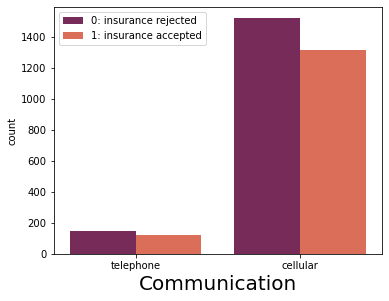

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.countplot(x="Communication" ,hue='CarInsurance', data=train_df ,palette='rocket')
plt.xlabel("Communication", fontsize=20)
plt.legend(("0: insurance rejected", "1: insurance accepted"),loc='best')



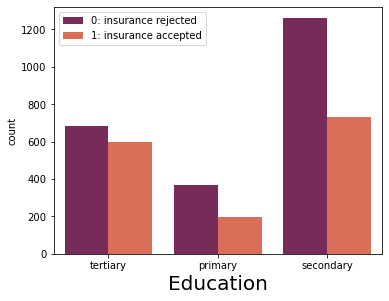

In [25]:
# COUNT PLOT OF EDUCATION

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.countplot(x="Education" ,hue='CarInsurance', data=train_df ,palette='rocket')
plt.xlabel("Education", fontsize=20)
plt.legend(("0: insurance rejected", "1: insurance accepted"),loc='best')



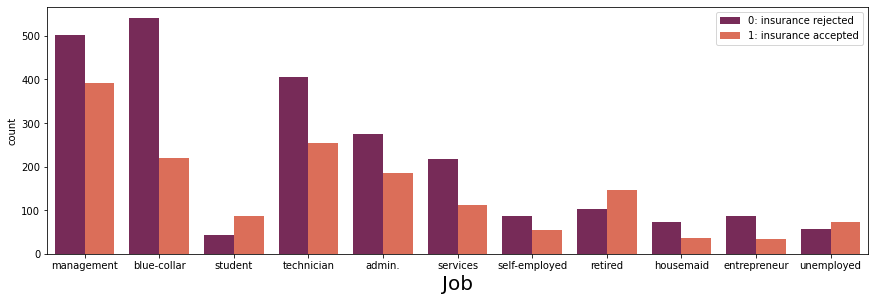

In [26]:
# COUNT PLOT OF JOB

plt.figure(figsize=(50,10))
plt.subplot(2,3,1)
sns.countplot(x="Job" ,hue='CarInsurance', data=train_df ,palette='rocket')
plt.xlabel("Job", fontsize=20)
plt.legend(("0: insurance rejected", "1: insurance accepted"),loc='best')


METHODOLOGY

In [59]:
# DEFINING INDEPENDENT AND DEPENDENT VARIABLES

X = train_data.drop('CarInsurance',axis =1)
y = train_data['CarInsurance']

In [60]:
# SPLITTING INTO TRAINING AND TESTING DATA HAVING 30% OF TEST DATA

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [61]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2800, 26) (1200, 26) (2800,) (1200,)


In [62]:
# SCALING THE DATA

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc.fit(X_train)

X_train = pd.DataFrame(sc.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X.columns)

LOGISTIC REGRESSION


TRAIN ACCURACY :  0.8053571428571429

TEST ACCURACY :  0.795

ACCURACY :  0.795

K-FOLD CROSS VALIDATION :  0.7592426759783353

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       726
           1       0.76      0.70      0.73       474

    accuracy                           0.80      1200
   macro avg       0.79      0.78      0.78      1200
weighted avg       0.79      0.80      0.79      1200


CONFUSION MATRIX:


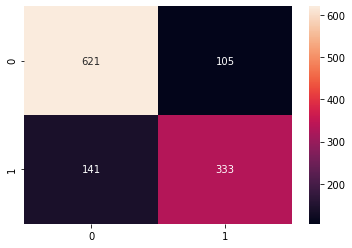

In [63]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model 
log = LogisticRegression(random_state = 0)

# Fitting data
log.fit(X_train, y_train)

# Predicting the data
log_pred = log.predict(X_test)


# MODEL EVALUATION FOR LOGISTIC REGRESSION
print("LOGISTIC REGRESSION\n")

# Train Accuracy
train = log.score(X_train, y_train)
print("\nTRAIN ACCURACY : ",train)

# Test Accuracy
test = log.score(X_test, y_test)
print("\nTEST ACCURACY : ",test)

# Accuracy
acc = accuracy_score(y_test,log_pred)
print("\nACCURACY : ",acc)

# KFold Cross Validation
kfold = KFold(n_splits=15)
results = cross_val_score(log, X, y,cv=kfold)
print("\nK-FOLD CROSS VALIDATION : ",results.mean())

# Classification Report
clf_report = classification_report(y_test,log_pred)
print("\nCLASSIFICATION REPORT:\n", clf_report)

# Confusion Matrix
print("\nCONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True,fmt='g')
plt.show()

DECISION TREE CLASSIFIER


TRAIN ACCURACY :  1.0

TEST ACCURACY :  0.7516666666666667

ACCURACY :  0.7516666666666667

K-FOLD CROSS VALIDATION :  0.7770052472003979

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       726
           1       0.70      0.65      0.67       474

    accuracy                           0.75      1200
   macro avg       0.74      0.73      0.74      1200
weighted avg       0.75      0.75      0.75      1200


CONFUSION MATRIX:


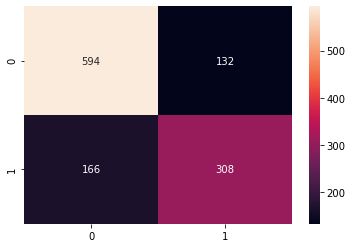

In [64]:
# DECISION TREE CLASSIFIER

# Decision Tree Classifier 
dec_tree = DecisionTreeClassifier()

# Fitting data
dec_tree.fit(X_train, y_train)

# Predicting the data
dec_tree_pred = dec_tree.predict(X_test)


# MODEL EVALUATION FOR DECISION TREE CLASSIFIER
print("DECISION TREE CLASSIFIER\n")

# Train Accuracy
train = dec_tree.score(X_train, y_train)
print("\nTRAIN ACCURACY : ",train)

# Test Accuracy
test = dec_tree.score(X_test, y_test)
print("\nTEST ACCURACY : ",test)

# Accuracy
acc = accuracy_score(y_test,dec_tree_pred)
print("\nACCURACY : ",acc)

# KFold Cross Validation
kfold = KFold(n_splits=15)
results = cross_val_score(dec_tree, X, y,cv=kfold)
print("\nK-FOLD CROSS VALIDATION : ",results.mean())

# Classification Report
clf_report = classification_report(y_test,dec_tree_pred)
print("\nCLASSIFICATION REPORT:\n", clf_report)

# Confusion Matrix
print("\nCONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test,dec_tree_pred),annot=True,fmt='g')
plt.show()

In [65]:
# BAGGING ENSEMBLES CLASSIFIER

bgclassifier = BaggingClassifier(base_estimator=dec_tree, n_estimators=20, max_features=10, max_samples=100)

# Fit the bagging classifier
bgclassifier.fit(X_train, y_train)


# MODEL EVALUATION FOR DECISION TREE CLASSIFIER
print("BAGGING ENSEMBLE CLASSIFIER\n")

# Train Accuracy
train = bgclassifier.score(X_train, y_train)
print("\nTRAIN ACCURACY : ",train)

# Test Accuracy
test = bgclassifier.score(X_test, y_test)
print("\nTEST ACCURACY : ",test)

BAGGING ENSEMBLE CLASSIFIER


TRAIN ACCURACY :  0.7328571428571429

TEST ACCURACY :  0.7025


HYPER PARAMETER TUNING

In [37]:
# LOGISTIC REGRESSION 
# Grid search

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

log_grid = {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],'penalty' : ['none','l1', 'l2', 'elasticnet'],'C' : [100, 10 ,1.0, 0.1, 0.01] }
log_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
log_grid_search = GridSearchCV(estimator=log, param_grid=log_grid, cv=log_cv, scoring='accuracy',error_score=0)
log_grid_result = log_grid_search.fit(X_train, y_train)

print("BEST PARAMETERS FOR LOGISTIC REGRESSION\n")
log_grid_result.best_params_

BEST PARAMETERS FOR LOGISTIC REGRESSION



{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [66]:
log_grid_predictions = log_grid_result.predict(X_test)

# Accuracy
acc = accuracy_score(y_test,log_grid_predictions)
print("\nACCURACY : ",acc)


ACCURACY :  0.795


LOGISTIC REGRESSION


TRAIN ACCURACY :  0.8046428571428571

TEST ACCURACY :  0.795

ACCURACY :  0.8

K-FOLD CROSS VALIDATION :  0.7970065613471883

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       726
           1       0.76      0.70      0.73       474

    accuracy                           0.80      1200
   macro avg       0.79      0.78      0.78      1200
weighted avg       0.79      0.80      0.79      1200


CONFUSION MATRIX:


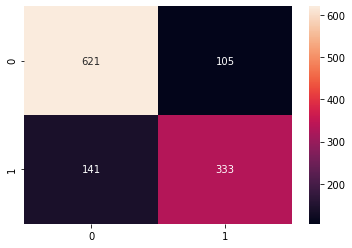

In [71]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model 
Hlog = LogisticRegression(C = 1.0, penalty = 'l1', solver = 'liblinear')

# Fitting data
Hlog.fit(X_train, y_train)

# Predicting the data
Hlog_pred = log.predict(X_test)


# MODEL EVALUATION FOR LOGISTIC REGRESSION
print("LOGISTIC REGRESSION\n")

# Train Accuracy
train = Hlog.score(X_train, y_train)
print("\nTRAIN ACCURACY : ",train)

# Test Accuracy
test = Hlog.score(X_test, y_test)
print("\nTEST ACCURACY : ",test)

# Accuracy
acc = accuracy_score(y_test,Hlog_pred)
print("\nACCURACY : ",acc.round(2))

# KFold Cross Validation
kfold = KFold(n_splits=15)
results = cross_val_score(Hlog, X, y,cv=kfold)
print("\nK-FOLD CROSS VALIDATION : ",results.mean())

# Classification Report
clf_report = classification_report(y_test,Hlog_pred)
print("\nCLASSIFICATION REPORT:\n", clf_report)

# Confusion Matrix
print("\nCONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test,Hlog_pred),annot=True,fmt='g')
plt.show()

In [40]:
# DECISION TREE CLASSIFIER


dt_model = DecisionTreeClassifier()

dt_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(1, 10),'min_samples_split':range(1,10),'min_samples_leaf':range(1,5)}
dt_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_grid, cv=dt_cv, scoring='accuracy',error_score=0)
dt_grid_result=dt_grid_search.fit(X_train,y_train) 

print("BEST PARAMETERS FOR DECISION TREE CLASSIFIER\n")
dt_grid_result.best_params_


BEST PARAMETERS FOR DECISION TREE CLASSIFIER



{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 9}

In [68]:
dt_grid_predictions = dt_grid_result.predict(X_test)

# Accuracy
acc = accuracy_score(y_test,dt_grid_predictions)
print("\nACCURACY : ",acc)


ACCURACY :  0.7733333333333333


DECISION TREE CLASSIFIER


TRAIN ACCURACY :  0.8292857142857143

TEST ACCURACY :  0.7716666666666666

ACCURACY :  0.7716666666666666

K-FOLD CROSS VALIDATION :  0.7952465433246036

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       726
           1       0.69      0.76      0.73       474

    accuracy                           0.77      1200
   macro avg       0.76      0.77      0.77      1200
weighted avg       0.78      0.77      0.77      1200


CONFUSION MATRIX:


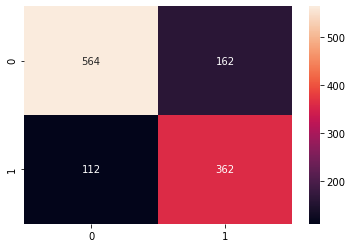

In [69]:
# DECISION TREE CLASSIFIER

# Decision Tree Classifier 
Hdec_tree = DecisionTreeClassifier(criterion= 'gini',max_depth= 6,min_samples_leaf= 2,min_samples_split= 9)

# Fitting data
Hdec_tree.fit(X_train, y_train)

# Predicting the data
Hdec_tree_pred = Hdec_tree.predict(X_test)


# MODEL EVALUATION FOR DECISION TREE CLASSIFIER
print("DECISION TREE CLASSIFIER\n")

# Train Accuracy
train = Hdec_tree.score(X_train, y_train)
print("\nTRAIN ACCURACY : ",train)

# Test Accuracy
test = Hdec_tree.score(X_test, y_test)
print("\nTEST ACCURACY : ",test)

# Accuracy
acc = accuracy_score(y_test,Hdec_tree_pred)
print("\nACCURACY : ",acc)

# KFold Cross Validation
kfold = KFold(n_splits=15)
results = cross_val_score(Hdec_tree, X, y,cv=kfold)
print("\nK-FOLD CROSS VALIDATION : ",results.mean())

# Classification Report
clf_report = classification_report(y_test,Hdec_tree_pred)
print("\nCLASSIFICATION REPORT:\n", clf_report)

# Confusion Matrix
print("\nCONFUSION MATRIX:")
sns.heatmap(confusion_matrix(y_test,Hdec_tree_pred),annot=True,fmt='g')
plt.show()

# NEW DATASET PREDICTION

In [43]:
# LOADING TRAIN DATA

test_df = pd.read_csv("carInsurance_test.csv")
print("----DATASET LOADED----")

----DATASET LOADED----


In [44]:
# PREVIEW OF THE DATA

test_df.head()

Id  Age         Job  Marital  Education  Default  Balance  HHInsurance  \
0  4001   25      admin.   single  secondary        0        1            1   
1  4002   40  management  married   tertiary        0        0            1   
2  4003   44  management   single   tertiary        0    -1313            1   
3  4004   27    services   single  secondary        0     6279            1   
4  4005   53  technician  married  secondary        0     7984            1   

   CarLoan Communication  LastContactDay LastContactMonth  NoOfContacts  \
0        1           NaN              12              may            12   
1        1      cellular              24              jul             1   
2        1      cellular              15              may            10   
3        0      cellular               9              nov             1   
4        0      cellular               2              feb             1   

   DaysPassed  PrevAttempts Outcome CallStart   CallEnd  CarInsurance  
0          -1             0     NaN  17:17:42  17:18:06           NaN  
1          -1             0     NaN  09:13:44  09:14:37           NaN  
2          -1             0     NaN  15:24:07  15:25:51           NaN  
3          -1             0     NaN  09:43:44  09:48:01           NaN  
4          -1             0     NaN  16:31:51  16:34:22           NaN

In [45]:
# CHECKING MISSING VALUES

test_df.isna().sum()

Id                     0
Age                    0
Job                    5
Marital                0
Education             47
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        221
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome              757
CallStart              0
CallEnd                0
CarInsurance        1000
dtype: int64

In [46]:
# MAPPING CATEGORICAL COLUMNS

test_df['Communication'] = test_df.Communication.map({'telephone' : 0, 'cellular' : 1})
test_df['Education'] =test_df.Education.map({'primary' : 1 , 'secondary' : 2, 'tertiary' : 3})
test_df['Marital'] = test_df.Marital.map({'single' : 1, 'married' : 2, 'divorced': 3})
test_df['LastContactMonth'] = test_df.LastContactMonth.map({'jan' :1, 'feb' : 2, 'mar' : 3, 'apr'  :4, 'may' :5, 'jun' : 6, 'jul' : 7, 'aug' :8, 'sep':9,  'oct' :10, 'nov' :11, 'dec' :12})

In [47]:
# HANDLING MISSING VALUES

def impute_nan(df,variable):
    most_frequent_category=df[variable].value_counts().mode()[0]
    df[variable].fillna(most_frequent_category,inplace=True)
    
for feature in ['Job','Education','Communication']:
    impute_nan(test_df,feature)


In [48]:
# ENCODING JOB FEATURES

def onehot_encode(test_df, columns):
    dummies = pd.get_dummies(test_df[columns], prefix = columns)
    test_df = pd.concat([test_df, dummies], axis =1)
    test_df = test_df.drop(columns, axis=1)
    
    return test_df

test_df = onehot_encode(test_df, 'Job')

In [49]:
# DROP OF OUTCOME ATTRIBUTE

test_df.drop(['Outcome'],axis =1, inplace = True)

In [50]:
# CALCULATING TOTAL CALL DURATION AND CONVERTING IT TO SECONDS

# Converting the type of "CallStart" & "CallEnd" to Datetime.
test_df[['CallStart','CallEnd']]=test_df[['CallStart','CallEnd']].astype('datetime64[ns]')

# Calculating the total Call Duration
test_df['Call_Duration']=test_df['CallEnd']-test_df['CallStart']

# Extracting the time & converting it to seconds
test_df['Call_Duration']=test_df['Call_Duration'].dt.components['minutes']*60 + test_df['Call_Duration'].dt.components['seconds']


In [51]:
# DROP OF UNWANTED COLUMNS

test_df.drop(['Id', 'CallEnd', 'CallStart'],axis =1, inplace = True)

In [52]:
# PREVIEW OF THE DATA

test_df.head()

Age  Marital  Education  Default  Balance  HHInsurance  CarLoan  \
0   25        1        2.0        0        1            1        1   
1   40        2        3.0        0        0            1        1   
2   44        1        3.0        0    -1313            1        1   
3   27        1        2.0        0     6279            1        0   
4   53        2        2.0        0     7984            1        0   

   Communication  LastContactDay  LastContactMonth  ...  Job_entrepreneur  \
0           81.0              12                 5  ...                 0   
1            1.0              24                 7  ...                 0   
2            1.0              15                 5  ...                 0   
3            1.0               9                11  ...                 0   
4            1.0               2                 2  ...                 0   

   Job_housemaid  Job_management  Job_retired  Job_self-employed  \
0              0               0            0                  0   
1              0               1            0                  0   
2              0               1            0                  0   
3              0               0            0                  0   
4              0               0            0                  0   

   Job_services  Job_student  Job_technician  Job_unemployed  Call_Duration  
0             0            0               0               0             24  
1             0            0               0               0             53  
2             0            0               0               0            104  
3             1            0               0               0            257  
4             0            0               1               0            151  

[5 rows x 27 columns]

In [53]:
# INFORMATION OF THE DATA

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1000 non-null   int64  
 1   Marital            1000 non-null   int64  
 2   Education          1000 non-null   float64
 3   Default            1000 non-null   int64  
 4   Balance            1000 non-null   int64  
 5   HHInsurance        1000 non-null   int64  
 6   CarLoan            1000 non-null   int64  
 7   Communication      1000 non-null   float64
 8   LastContactDay     1000 non-null   int64  
 9   LastContactMonth   1000 non-null   int64  
 10  NoOfContacts       1000 non-null   int64  
 11  DaysPassed         1000 non-null   int64  
 12  PrevAttempts       1000 non-null   int64  
 13  CarInsurance       0 non-null      float64
 14  Job_14             1000 non-null   uint8  
 15  Job_admin.         1000 non-null   uint8  
 16  Job_blue-collar    1000 n

In [54]:
# INFORMATION OF THE DATA

test_df.columns

Index(['Age', 'Marital', 'Education', 'Default', 'Balance', 'HHInsurance',
       'CarLoan', 'Communication', 'LastContactDay', 'LastContactMonth',
       'NoOfContacts', 'DaysPassed', 'PrevAttempts', 'CarInsurance', 'Job_14',
       'Job_admin.', 'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Job_unemployed', 'Call_Duration'],
      dtype='object')

In [55]:
log.fit(X,y)
X_test = test_df.drop("CarInsurance", axis = 1)
test_df["CarInsurance"] = log.predict(X_test)
test_df["CarInsurance"] = test_df["CarInsurance"].apply(lambda x: "will not buy insurance" if x==0 else "will buy insurance")


columns = ['Age', 'Marital', 'Education', 'Default', 'Balance', 'HHInsurance','CarLoan', 'Communication', 'LastContactDay', 
           'LastContactMonth','NoOfContacts', 'DaysPassed', 'PrevAttempts', 'Job_14','Job_admin.', 
           'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid','Job_management', 'Job_retired', 'Job_self-employed', 
           'Job_services', 'Job_student', 'Job_technician', 'Job_unemployed', 'Call_Duration', 'CarInsurance']


test_df = test_df[columns]
test_df["CarInsurance"].value_counts()

will not buy insurance    637
will buy insurance        363
Name: CarInsurance, dtype: int64

In [56]:
test_df.to_csv("Insurance Purchase Forcast.csv")

In [57]:
test_df.head(10)

Age  Marital  Education  Default  Balance  HHInsurance  CarLoan  \
0   25        1        2.0        0        1            1        1   
1   40        2        3.0        0        0            1        1   
2   44        1        3.0        0    -1313            1        1   
3   27        1        2.0        0     6279            1        0   
4   53        2        2.0        0     7984            1        0   
5   28        1        3.0        0    12956            1        0   
6   39        2        2.0        0     1044            1        0   
7   50        2        3.0        0      414            1        0   
8   56        3        3.0        0      408            1        0   
9   36        2        2.0        0     1006            1        0   

   Communication  LastContactDay  LastContactMonth  ...  Job_housemaid  \
0           81.0              12                 5  ...              0   
1            1.0              24                 7  ...              0   
2            1.0              15                 5  ...              0   
3            1.0               9                11  ...              0   
4            1.0               2                 2  ...              0   
5            1.0               2                 7  ...              0   
6            1.0               2                 2  ...              0   
7            1.0               3                 4  ...              0   
8           81.0              27                 5  ...              0   
9            1.0              21                11  ...              0   

   Job_management  Job_retired  Job_self-employed  Job_services  Job_student  \
0               0            0                  0             0            0   
1               1            0                  0             0            0   
2               1            0                  0             0            0   
3               0            0                  0             1            0   
4               0            0                  0             0            0   
5               1            0                  0             0            0   
6               0            0                  0             0            0   
7               1            0                  0             0            0   
8               1            0                  0             0            0   
9               0            0                  1             0            0   

   Job_technician  Job_unemployed  Call_Duration            CarInsurance  
0               0               0             24  will not buy insurance  
1               0               0             53  will not buy insurance  
2               0               0            104  will not buy insurance  
3               0               0            257  will not buy insurance  
4               1               0            151  will not buy insurance  
5               0               0            940      will buy insurance  
6               0               0            158  will not buy insurance  
7               0               0            707      will buy insurance  
8               0               0            274  will not buy insurance  
9               0               0             89  will not buy insurance  

[10 rows x 27 columns]

# INFERENCE

      
       MODEL  USED               TRAIN ACCURACY    TEST ACCURACY
    
    LOGISTIC REGRESSION      :       80%               79%
    
    DECISION TREE CLASSIFIER :       100%              74%
    
    BAGGING CLASSIFIER       :       74%               75% 
    
    The model is overfitted, so bagging classifier is used to avoid it.

    BEFORE HYPER-PARAMETER TUNING                              AFTER HYPER-PARAMETER TUNING

    LOGISTIC REGRESSION                                        LOGISTIC REGRESSION
        K fold cross validation  : 75%                             K fold cross validation  : 79%
                        Accuracy : 79%                                             Accuracy : 80%
                       Precision : 79%                                            Precision : 79%
                          Recall : 80%                                               Recall : 80%
                        F1 Score : 79%                                             F1 Score : 79%
    

    DECISION TREE CLASSIFIER                                  DECISION TREE CLASSIFIER
        K fold cross validation  : 77%                            K fold cross validation  : 79%
                        Accuracy : 74%                                            Accuracy : 77%
                       Precision : 74%                                           Precision : 78%
                          Recall : 74%                                              Recall : 77%
                        F1 Score : 74%                                            F1 Score : 77%


     By comparing the model performance metrices , the effectiveness of the algorithm was calculated.
     Logistic regression has the highest accuracy of about 80% and 
     decision tree classifier has an accuracy of 77% after hyper parameter tuning.
     Therefore, Logistic Regression is used to predict whether the customer will claim insurance or not.


In [ ]:
## IDENTIFICATION OF PROSPECTIVE CUSTOMERS FOR CAR INSURANCE